In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from typing import List

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit.Chem import PandasTools, QED, AllChem, Draw, rdFMCS
from rdkit.Chem import rdRGroupDecomposition as rdRGD

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sascorer import calculateScore
#from cddd_preprocessing import preprocess_smiles
import import_ipynb
import sascorer

In [2]:
df_input = pd.read_csv('data/original_molecules.csv')
df_input = df_input.rename(columns={'ALOGP': 'LogP'})
print('Number of AChE inhibitors: ',df_input[df_input['Target'] == 'AChE'].shape[0])
print('Number of BACE inhibitors: ',df_input[df_input['Target'] == 'BACE1'].shape[0])
print('Number of GSK3 inhibitors: ',df_input[df_input['Target'] == 'GSK3'].shape[0])

Number of AChE inhibitors:  69
Number of BACE inhibitors:  527
Number of GSK3 inhibitors:  246


In [3]:
# Generated molecules
df_AB = pd.read_csv('generated_molecules/A8B8_pool_500.csv', index_col = 0)
df_AG = pd.read_csv('generated_molecules/A8G8_pool_500.csv', index_col = 0)
df_GB = pd.read_csv('generated_molecules/G8B8_pool_500.csv', index_col = 0)

In [4]:
df_GB

,smiles_g,A_Best,A_score,B_Best,B_score,epoch,generator,Target,QED_score,SA_score,MW,LogP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,[CH]C(O)(CC1CCCC1)c1ccccc1O[O],O=C(Nc1n[nH]c2ncc(-c3ccccc3)cc12)C1CCCC1,0.260870,COC1CCC2(CC1)Cc1ccc(OCC3CCCC3)cc1C21N=C(N)N(C)...,0.218182,245,AtoB,GB(high) MTDL,0.641782,3.621818,233.287,2.88989,2,1,49.36,4,1,2
1,CCC(=[N+]1CCCCC1)c1cc(Cl)ccc1OCC,CCOc1ccncc1NC(=O)c1ccnc2[nH]c(-c3cccc(OC)c3)nc12,0.179487,CC1(c2cc(NC(=O)c3ccc(Cl)cn3)ccc2F)CS(=O)(=O)C2...,0.201681,245,AtoB,GB(high) MTDL,0.755396,2.935090,280.819,4.13420,1,0,12.24,4,1,1
2,CCCC1(OCC(C)=[O+]C)CCc2ccccc21,CCCC(=O)Nc1n[nH]c2c(F)c(Cl)c(-c3ccccc3)cc12,0.183673,CN1C(=O)C2(NC1N)c1cc(OCC3CC3)ccc1OC21CCc2ccccc...,0.206897,245,AtoB,GB(high) MTDL,0.730326,3.984335,247.358,3.39930,1,0,20.53,5,1,1
3,CCCC(C)([N+](=O)[O-])c1ccccc1Cl,CCCC(=O)Nc1n[nH]c2c(F)c(Cl)c(-c3ccccc3)cc12,0.235294,CN1C(=N)NC(C)(c2sc(-c3ccc(-c4ccccc4)[nH]3)cc2C...,0.180000,245,AtoB,GB(high) MTDL,0.582362,3.104196,227.691,3.63200,2,0,43.14,4,1,2
4,CCCC1(O)c2ccccc2OC1=[O+]CCCC,CCCC(=O)Nc1n[nH]c2c(F)c(Cl)c(-c3ccccc3)cc12,0.183673,CC(=O)NC(Cc1ccccc1)C(O)CNC1CC2(CCC2)Oc2ncc(CC(...,0.170732,245,AtoB,GB(high) MTDL,0.377083,3.909175,249.330,2.92910,2,1,40.76,5,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136034,COc1ccc(-c2cccnc2NC(=O)C2CCC(N)C2)cc1S(C)=O,COc1cc(-c2ccnc(NC(=O)C3CC3)c2)cnc1C(N)=O,0.383838,COC1CCC2(CC1)Cc1ccc(-c3cccnc3F)cc1C21N=C(N)N(C...,0.316667,122999,BtoA,GB(high) MTDL,0.839921,3.570926,373.478,2.56050,5,2,94.31,5,2,0
136035,COC(=O)c1ccccc1-c1ccnc(NC(=O)C2CCN(C)C2)c1,COc1nc(-c2ccnc(NC(=O)C3CC3)c2)ncc1C(N)=O,0.421053,COC1CCC2(CC1)Cc1ccc(-c3cccnc3F)cc1C21N=C(N)N(C...,0.278689,122999,BtoA,GB(high) MTDL,0.866397,2.558688,339.395,2.42540,5,1,71.53,4,2,1
136036,O=C(Nc1ccccc1)c1cc(-c2cncc3ccccc23)[nH]c1CCO,COc1ccccc1C(=O)Nc1n[nH]c2ccc(-c3cn(Cc4ccccc4)n...,0.362205,CN1C(=O)CC(C)(c2cccc(NC(=O)c3ccc(Cl)cn3)c2)N=C1N,0.247934,122999,BtoA,GB(high) MTDL,0.504781,2.424622,357.413,4.01700,3,3,78.01,5,4,0
136037,Cn1cc(C2=C(c3ccccc3O)C(=O)NC2=O)c2ccc(Cl)cc21,Cn1cc(C2=C(c3cc(Cl)ccc3Cl)C(=O)NC2=O)c2ccccc21,0.750000,CN1C(=N)NC(C)(c2sc(-c3ccc(-c4ccccc4)[nH]3)cc2C...,0.275862,122999,BtoA,GB(high) MTDL,0.696072,2.442777,352.777,3.10450,3,2,71.33,2,3,1


In [2]:
def Chem_scores(df):
    df = df.reset_index()
    df['mols'] = df[df.columns[0]].apply(lambda x: Chem.MolFromSmiles(x))
    #df['mols'].apply(lambda x: Chem.AddHs(x)) # This will be added in Chimera
    #df['mols'].apply(lambda x: AllChem.EmbedMolecule(x))
    #df['mols'].apply(lambda x: AllChem.ComputeGasteigerCharges(x))
    df['QED_score'] = df['mols'].apply(lambda x: QED.qed(x))
    df['SA_score'] = df['mols'].apply(lambda x: sascorer.calculateScore(x))
    df['MW'] = df['mols'].apply(lambda x: QED.properties(x)[0])
    df['ALOGP'] = df['mols'].apply(lambda x: QED.properties(x)[1])
    df['HBA'] = df['mols'].apply(lambda x: QED.properties(x)[2])
    df['HBD'] = df['mols'].apply(lambda x: QED.properties(x)[3])
    df['PSA'] = df['mols'].apply(lambda x: QED.properties(x)[4])
    df['ROTB'] = df['mols'].apply(lambda x: QED.properties(x)[5])
    df['AROM'] = df['mols'].apply(lambda x: QED.properties(x)[6])
    df['ALERTS'] = df['mols'].apply(lambda x: QED.properties(x)[7])
    df = df.set_index(df.columns[0])
    return df

## https://github.com/PatWalters/workshop/blob/master/predictive_models/2_visualizing_chemical_space.ipynb
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


In [3]:
# 'chembl_activity_whole_preprocessed.csv' contains preprocessed SMILES strings
df_activity = pd.read_csv('chembl_activity_whole_preprocessed.csv', index_col = 0)
df_activity['Molecule Name'] = df_activity['Molecule Name'].apply(lambda x: str(x).lower())

AD_targets = ['Acetylcholinesterase', 'Beta-secretase 1', 'Glycogen synthase kinase-3 beta']
features = ['pChEMBL Value', 'Target Name', 'AlogP', 'Molecule Name', 'Molecule ChEMBL ID', 'Molecule Max Phase', 'Smiles_preprocessed']

df_AD = df_activity[df_activity['Target Name'].isin(AD_targets)]
df_AD = df_AD[features]

## ACHE, BACE1, GSK3
df_pivot = df_AD.pivot_table(values = 'pChEMBL Value', index = 'Smiles_preprocessed', columns = 'Target Name', aggfunc = 'mean')
df_pivot = df_pivot.groupby('Smiles_preprocessed').fillna(0)

target_instance = np.count_nonzero(df_pivot, axis = 0)
smiles_instance = np.count_nonzero(df_pivot, axis = 1)
smiles_instance = smiles_instance.reshape(-1, 1)


df_multi = df_pivot.loc[smiles_instance >= 2]

df_BACE1 = df_pivot[(df_pivot['Beta-secretase 1'] != 0) & (~df_pivot.index.isin(df_multi.index))]
df_ACHE = df_pivot[(df_pivot['Acetylcholinesterase'] != 0) & (~df_pivot.index.isin(df_multi.index))]
df_GSK3 = df_pivot[(df_pivot['Glycogen synthase kinase-3 beta'] != 0) & (~df_pivot.index.isin(df_multi.index))]


df_BACE1 = Chem_scores(df_BACE1)
df_ACHE = Chem_scores(df_ACHE)
df_GSK3 = Chem_scores(df_GSK3)

df_ACHE['Target'] = 'AChE'
df_BACE1['Target'] = 'BACE1'
df_GSK3['Target'] = 'GSK3'

df_input = pd.concat([df_ACHE, df_BACE1, df_GSK3]).reset_index()
print(df_input.shape)

# Filter 1 -> MW weight less than 500 Da
df_input_f1 = df_input[(df_input['MW'] < 500) & (df_input['MW'] > 300)].reset_index(drop = True)
print(df_input_f1.shape)
# Filter 2 -> LogP less than 5
df_input_f2 = df_input_f1[df_input_f1['ALOGP'] < 5].reset_index(drop = True)
print(df_input_f2.shape)

# Filter 3 -> Binding affinity 10nM ~ 1nM
df_A = df_ACHE[(df_ACHE['MW'] < 500) & (df_ACHE['MW'] > 300) &
        (df_ACHE['Acetylcholinesterase'] >= 8)
               &(df_ACHE['Acetylcholinesterase'] <= 9)
               &(df_ACHE['ALOGP'] < 5)
              ]
#df_A['Target'] = 'AChE'
print(df_A.shape)

df_B = df_BACE1[(df_BACE1['MW'] < 500) & (df_BACE1['MW'] > 300) &
         (df_BACE1['Beta-secretase 1'] >= 8)
                &(df_BACE1['Beta-secretase 1'] <= 9)
                &(df_BACE1['ALOGP'] < 5)
               ]
#df_B['Target'] = 'BACE1'
print(df_B.shape)

df_G = df_GSK3[(df_GSK3['MW'] < 500) & (df_GSK3['MW'] > 300) &
        (df_GSK3['Glycogen synthase kinase-3 beta'] >= 8)
               &(df_GSK3['Glycogen synthase kinase-3 beta'] <= 9)
               &(df_GSK3['ALOGP'] < 5)
              ]
#df_G['Target'] = 'GSK3'
print(df_G.shape)

df_input_f3 = pd.concat([df_A, df_B, df_G])
df_input_f3 = df_input_f3.reset_index()
print(df_input_f3.shape)

/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_4755/907778299.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_activity = pd.read_csv('chembl_activity_whole_preprocessed.csv', index_col = 0)
/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_4755/907778299.py:13: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  df_pivot = df_pivot.groupby('Smiles_preprocessed').fillna(0)


(12039, 16)
(9227, 16)
(7996, 16)
(69, 15)
(527, 15)
(246, 15)
(842, 16)


In [31]:
print(df_ACHE.shape, df_BACE1.shape, df_GSK3.shape)

(3312, 15) (5816, 15) (2911, 15)


### tSNE

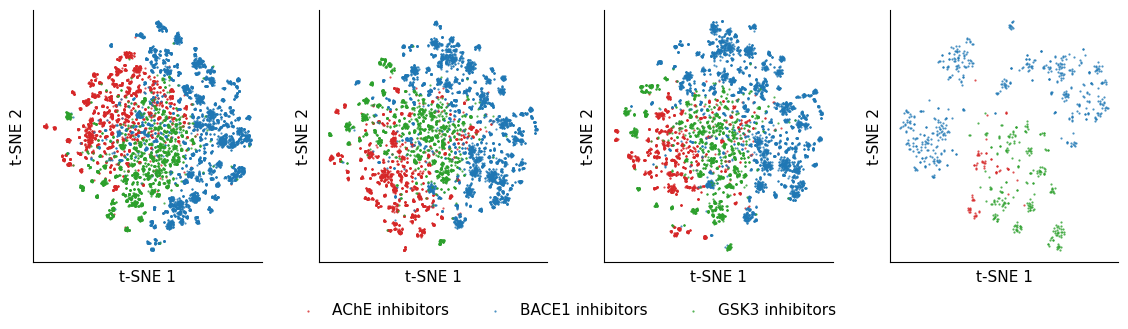

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdFingerprintGenerator
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# ---------- Configuration ----------
RANDOM_STATE = 42
PERPLEXITY   = 30
N_ITER       = 1500
N_BITS       = 2048
RADIUS       = 2
POINT_SIZE   = 2.5
POINT_ALPHA  = 0.8

# Legend labels with "inhibitors"
LABELS  = {'AChE': 'AChE inhibitors',
           'BACE1': 'BACE1 inhibitors',
           'GSK3': 'GSK3 inhibitors'}

COLOURS = {'AChE': '#D62728',
           'BACE1': '#1F77B4',
           'GSK3': '#2CA02C'}

PANELS = [
    ("", df_input),
    ("", df_input_f1),
    ("", df_input_f2),
    ("", df_input_f3),
]

# Fingerprint generation
_gen = rdFingerprintGenerator.GetMorganGenerator(radius=RADIUS, fpSize=N_BITS)

def fp_from_smiles(smiles: str):
    mol = Chem.MolFromSmiles(str(smiles))
    if mol is None:
        return None
    fp = _gen.GetFingerprint(mol)
    arr = np.zeros((N_BITS,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Data preparation
def build_matrix(df):
    sub = df[df['Target'].isin(LABELS.keys())].copy()
    sub['_fp'] = sub['Smiles_preprocessed'].apply(fp_from_smiles)
    sub = sub[sub['_fp'].notna()].copy()
    if sub.empty:
        raise ValueError("No valid molecules after SMILES→fingerprint.")
    X = np.vstack(sub['_fp'].values).astype(float)
    return sub, X


# ---------- tSNE ----------

# tSNE embedding function
def tsne_embed(X):
    Xs = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
    tsne = TSNE(
        n_components=2,
        perplexity=PERPLEXITY,
        n_iter=N_ITER,
        learning_rate='auto',
        init='pca',
        metric='cosine',
        random_state=RANDOM_STATE,
        verbose=0
    )
    return tsne.fit_transform(Xs)

# Run tSNE
os.makedirs('fig_tsne', exist_ok=True)

embeds = []
for _, dfp in PANELS:
    sub, X = build_matrix(dfp)
    emb = tsne_embed(X)
    df_emb = sub[['Target']].copy()
    df_emb['TSNE1'] = emb[:, 0]
    df_emb['TSNE2'] = emb[:, 1]
    embeds.append(df_emb)

# ---------- Plot & Save ----------

# Plotting function
def style_axes(ax):
    ax.set_xlabel('t-SNE 1', labelpad=6)
    ax.set_ylabel('t-SNE 2', labelpad=6)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)

def scatter_panel(ax, df_emb):
    for cls in LABELS.keys():
        m = (df_emb['Target'] == cls)
        if m.any():
            ax.scatter(
                df_emb.loc[m, 'TSNE1'], df_emb.loc[m, 'TSNE2'],
                s=POINT_SIZE, alpha=POINT_ALPHA, linewidths=0,
                color=COLOURS[cls], label=LABELS[cls]
            )
    style_axes(ax)

plt.rcParams.update({'pdf.fonttype': 42, 'ps.fonttype': 42,
                     'font.size': 11, 'axes.linewidth': 0.8})

fig, axes = plt.subplots(1, 4, figsize=(14, 3.6))
for ax, df_emb in zip(axes, embeds):
    scatter_panel(ax, df_emb)

# Legends
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',
           ncol=3, frameon=False,
           handletextpad=0.6, borderpad=0.2)
plt.subplots_adjust(wspace=0.25, bottom=0.18)
plt.show()


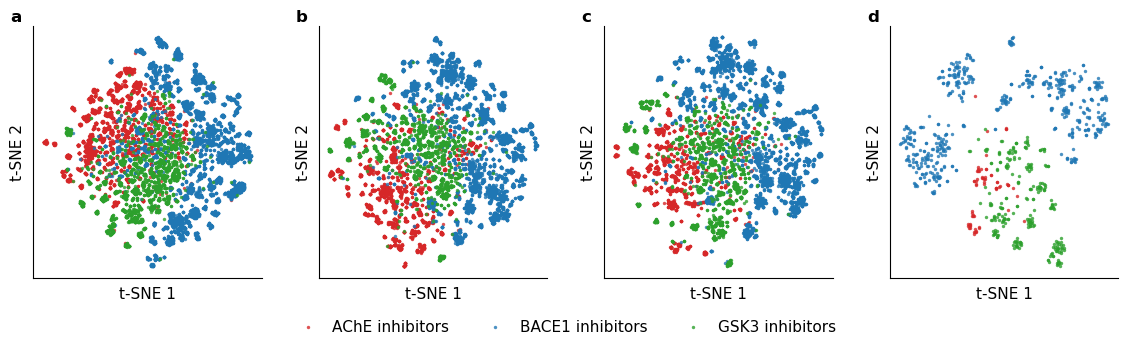

In [39]:
POINT_SIZE   = 6
POINT_ALPHA  = 0.8

# Plotting function
def style_axes(ax):
    ax.set_xlabel('t-SNE 1', labelpad=6)
    ax.set_ylabel('t-SNE 2', labelpad=6)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)

def scatter_panel(ax, df_emb):
    for cls in LABELS.keys():
        m = (df_emb['Target'] == cls)
        if m.any():
            ax.scatter(
                df_emb.loc[m, 'TSNE1'], df_emb.loc[m, 'TSNE2'],
                s=POINT_SIZE, alpha=POINT_ALPHA, linewidths=0,
                color=COLOURS[cls], label=LABELS[cls]
            )
    style_axes(ax)

plt.rcParams.update({'pdf.fonttype': 42, 'ps.fonttype': 42,
                     'font.size': 11, 'axes.linewidth': 0.8})

fig, axes = plt.subplots(1, 4, figsize=(14, 3.6))
for ax, df_emb in zip(axes, embeds):
    scatter_panel(ax, df_emb)

# Legends
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',
           ncol=3, frameon=False,
           handletextpad=0.6, borderpad=0.2)
plt.subplots_adjust(wspace=0.25, bottom=0.18)

# Panel letters outside, top-left of each subplot
panel_labels = ['a', 'b', 'c', 'd']
y_offset = 0.005             # vertical gap above each axes
x_shift_frac = 0.1          # move left by 10% of each axes' width

for ax, lab in zip(axes.ravel(), panel_labels):
    bb = ax.get_position()   # figure coords
    x = max(bb.x0 - x_shift_frac * bb.width, 0.0)
    fig.text(x, bb.y1 + y_offset, lab,
             ha='left', va='bottom',
             fontsize=12, fontweight='bold')

fig.savefig('result_fig/TSNE_highres.png', dpi=600, bbox_inches='tight')
plt.show()